In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, astropy.units as u, seaborn as sns, astropy, matplotlib as mpl
from matplotlib.lines import Line2D
from astropy.io import fits, ascii as ascii_io
from astropy.coordinates import SkyCoord, Angle
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad

plt.rcParams["font.size"] = "20"

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


In [2]:
simbad = pd.read_csv("../catalogs/BeSS_Simbad_GaiaDist.csv",dtype={'id':str})
old = pd.read_csv("../catalogs/BeSS+Gaia+HMXBs+CSC+XMM.csv")

old[["epsi","AG"]] = old[["epsi","AG"]].apply(pd.to_numeric, errors="coerce")
old["N_H"] = old["AG"].values*2.2e21
old["DR2Name"] = [str(entry).split()[-1][:-1] for entry in old["DR2Name"]]

total = pd.merge(simbad,old,on="Be star")[["_RAJ2000","_DEJ2000","Be star","SpecType","main_type","DR2Name","pmRA","pmDE","rest","epsi","sepsi","AG","N_H","_2CXO","_4XMM"]].drop_duplicates()
total

,_RAJ2000,_DEJ2000,Be star,SpecType,main_type,DR2Name,pmRA,pmDE,rest,epsi,sepsi,AG,N_H,_2CXO,_4XMM
0,0.352917,63.504369,BD+62 2346,B0Ve,Be*,431593257757382912,0.970,-3.830,1153.442143,0.186,13.90,NaN,NaN,NaN,NaN
1,0.410958,60.449922,HD 224905,B1Vne,Be*,429341153012514176,-3.183,-1.434,1465.679924,0.000,0.00,0.6860,1.509200e+21,NaN,NaN
2,0.863125,55.550897,HD 225095,B2IVne,Em*,420875841188703360,-2.137,-1.519,1254.419479,0.066,1.70,0.3683,8.102600e+20,NaN,NaN
3,0.934958,-17.335992,2 Cet,B9IVne,Star,2414783622022208128,25.559,-9.180,94.255370,1.089,539.00,0.3510,7.722000e+20,NaN,NaN
4,1.610583,64.196169,10 Cas,B9IIIe,Be*,431696822314371456,9.036,0.804,301.387828,0.380,56.00,0.4410,9.702000e+20,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2172,359.392083,66.431622,BD+65 1970,B5e,**,2209768920129221760,-3.325,9.166,4442.416945,2.051,614.00,NaN,NaN,NaN,NaN
2173,359.693500,46.413178,LQ And,B4Vne,Be*,1926411961766632960,15.419,0.574,409.092285,0.150,9.97,0.3600,7.920000e+20,NaN,NaN
2174,359.705167,32.381706,HD 224544,B6IVe,Be*,2873823129549261056,1.612,-3.061,607.342863,0.237,28.90,0.1607,3.535400e+20,NaN,NaN
2175,359.812375,60.022481,HD 224599,B0.5Vnnpe,Be*,1999574461912020736,-3.093,-1.844,2769.539308,0.000,0.00,0.9072,1.995840e+21,NaN,NaN


In [3]:
for i in total.index:
    if pd.isna(total.loc[i,"_2CXO"]) and pd.isna(total.loc[i,"_4XMM"]):
        total.loc[i,"Catalog membership"] = "Gaia only"
    elif pd.isna(total.loc[i,"_2CXO"]):
        total.loc[i,"Catalog membership"] = "Gaia+XMM"
    elif pd.isna(total.loc[i,"_4XMM"]):
        total.loc[i,"Catalog membership"] = "Gaia+Chandra"
    else:
        total.loc[i,"Catalog membership"] = "Gaia+Chandra+XMM"

for i in total.index:
    if total.loc[i,"main_type"] in ["Ae*","Be*","*","Em*","Star",'*  ','~  ', "s*b","IR","HII","sg*","SG*","post-AGB*","RB?","Candidate_Be*","Candidate_RGB*","BlueSG*","Radio","Radio(sub-mm)","Cl*"]:
        #total.drop(i, axis=0, inplace=True)
        continue
    elif total.loc[i,"main_type"] in ["Al*","EB*","SB*","** ","**","WU*","bL*","*in**",'EB*WUMa', 'EB*betLyr','EB*Algol',"multiple_object"]:
        total.loc[i,"Class"] = "Binary"
    elif total.loc[i,"main_type"] in ["Pe*","WR*","Pec*"]:
        total.loc[i,"Class"] = "Peculiar/WR"
    elif total.loc[i,"main_type"] in ["Y*?", "Y*O","Candidate_YSO","YSO"]:
        total.loc[i,"Class"] = "YSO"
    elif total.loc[i,"main_type"] in ["*iN","pA*","*inNeb","RfNeb"]:
        total.loc[i,"Class"] = "Nebular"
    elif total.loc[i,"main_type"] in ["Eruptive*","Er*","Orion_V*","Pu*","V* ",'a2*','bC*',"V*","PulsV*bCep","PulsV*","RotV*alf2CVn"]:
        total.loc[i,"Class"] = "Variable"
    elif total.loc[i,"main_type"] in ["HXB","HMXB"]:
        total.loc[i,"Class"] = "HMXB"

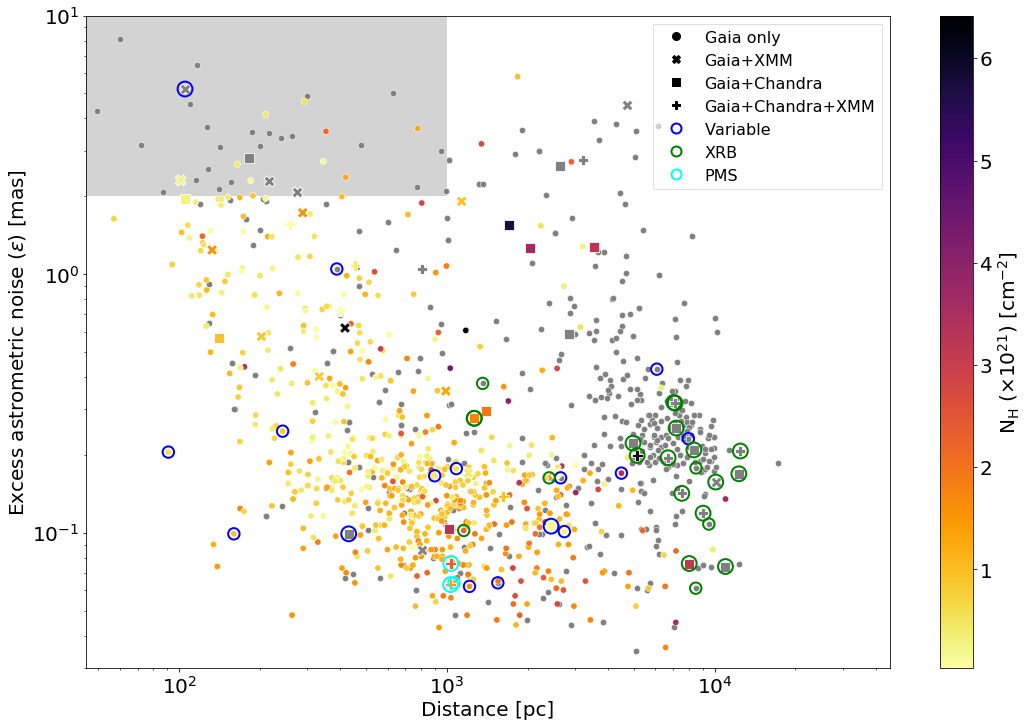

In [13]:
fig, ax = plt.subplots(figsize=(18,12))#, facecolor="lightgrey")
#plt.grid(color="silver",linestyle=":")

ax.add_patch(mpl.patches.Rectangle((0,2),1000,50, edgecolor='none',facecolor='lightgrey',zorder=0))


markers = {"Gaia only":"o","Gaia+XMM":"X","Gaia+Chandra":"s","Gaia+Chandra+XMM":"P"}
sizes = dict(zip(markers.keys(), [40,120,100,120]))
for cat, frame in total.groupby("Catalog membership"):
    sns.scatterplot(data=total[total["N_H"].isna() & (total["Catalog membership"]==cat)], x="rest", y="epsi", color="grey", marker=markers[cat], s=sizes[cat], ax=ax, legend=True)
    sns.scatterplot(data=total[~total["N_H"].isna() & (total["Catalog membership"]==cat)],x="rest",y="epsi",hue="N_H",palette="inferno_r",marker=markers[cat],s=sizes[cat],ax=ax, legend=True)

ax.scatter(total[total["Class"]=="Variable"]["rest"], total[total["Class"]=="Variable"]["epsi"], s=[130 if total[total["Class"]=="Variable"]["Catalog membership"][i]=="Gaia only" else 220 for i in total[total["Class"]=="Variable"].index], linewidth=2, facecolors='none', edgecolors="b", label="Variable")
ax.scatter(total[total["Class"]=="HMXB"]["rest"], total[total["Class"]=="HMXB"]["epsi"], s=[130 if total[total["Class"]=="HMXB"]["Catalog membership"][i]=="Gaia only" else 220 for i in total[total["Class"]=="HMXB"].index], linewidth=2, facecolors='none', edgecolors="g", label="HMXB")
ax.scatter(total[total["Class"]=="YSO"]["rest"], total[total["Class"]=="YSO"]["epsi"], s=[130 if total[total["Class"]=="YSO"]["Catalog membership"][i]=="Gaia only" else 220 for i in total[total["Class"]=="YSO"].index], linewidth=2, facecolors='none', edgecolors="cyan", label="YSO")

ax.set(ylim=(3e-2,10), xlim=(45,45000), xscale="log", yscale="log", xlabel="Distance [pc]", ylabel="Excess astrometric noise ($\epsilon$) [mas]")

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=total["N_H"].min()/1e21, vmax=total["N_H"].max()/1e21, clip=False), cmap='inferno_r'),label='N$_\mathrm{H}$ (×$10^{21}$) [cm$^{-2}$]',ax=ax)

legend_elements = [Line2D([0], [0], linestyle="", marker=mark, color="k", label=lbl, markersize=8) for lbl,mark in markers.items()]+[Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='b', label='Variable', markersize=10, mew=2),
                   Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='g', label='XRB', markersize=10, mew=2),
                   Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper right', fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))


fig.savefig("../plots/gaia_epsi_vs_rest.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

In [5]:
total["pm"] = np.sqrt(total["pmRA"]**2 + total["pmDE"]**2)*2.77777778e-07 # magnitude of the proper motion vector in deg/yr
total["Vel"] = total["rest"]*np.tan(total["pm"]) # pc/yr

In [6]:
crit = total[(total["epsi"] > 2) & (total["rest"] < 1000)]

# import HEASARC matches
swift = pd.read_csv("../catalogs/heasarc_swiftmastr.txt", header=2, delimiter="|").drop(["Unnamed: 0","Unnamed: 12"],axis=1)
swiftlog = pd.read_csv("../catalogs/heasarc_swiftxrlog.txt", header=2, delimiter="|").drop(["Unnamed: 0","Unnamed: 12"],axis=1)
XMM = pd.read_csv("../catalogs/heasarc_xmmmaster.txt", header=2, delimiter="|").drop(["Unnamed: 0","Unnamed: 13"],axis=1)
Chandra = pd.read_csv("../catalogs/heasarc_chanmaster.txt", header=2, delimiter="|").drop(["Unnamed: 0","Unnamed: 14"],axis=1)

In [7]:
# parse _Search_Offset column into usable offset and coordinate info
swift["_RAJ2000"] = pd.to_numeric([str(entry).split()[-1].replace("(","").split(",")[0] for entry in swift["_Search_Offset"]])
swift["_DEJ2000"] = pd.to_numeric([str(entry).split()[-1].replace(")","").split(",")[-1] for entry in swift["_Search_Offset"]])
swift["Offset"] = pd.to_numeric([str(entry).split()[0] for entry in swift["_Search_Offset"]])
swiftlog["_RAJ2000"] = pd.to_numeric([str(entry).split()[-1].replace("(","").split(",")[0] for entry in swiftlog["_Search_Offset"]])
swiftlog["_DEJ2000"] = pd.to_numeric([str(entry).split()[-1].replace(")","").split(",")[-1] for entry in swiftlog["_Search_Offset"]])
swiftlog["Offset"] = pd.to_numeric([str(entry).split()[0] for entry in swiftlog["_Search_Offset"]])
XMM["_RAJ2000"] = pd.to_numeric([str(entry).split()[-1].replace("(","").split(",")[0] for entry in XMM["_Search_Offset"]])
XMM["_DEJ2000"] = pd.to_numeric([str(entry).split()[-1].replace(")","").split(",")[-1] for entry in XMM["_Search_Offset"]])
XMM["Offset"] = pd.to_numeric([str(entry).split()[0] for entry in XMM["_Search_Offset"]])
Chandra["_RAJ2000"] = pd.to_numeric([str(entry).split()[-1].replace("(","").split(",")[0] for entry in Chandra["_Search_Offset"]])
Chandra["_DEJ2000"] = pd.to_numeric([str(entry).split()[-1].replace(")","").split(",")[-1] for entry in Chandra["_Search_Offset"]])
Chandra["Offset"] = pd.to_numeric([str(entry).split()[0] for entry in Chandra["_Search_Offset"]])

# apply filters
swift = swift[(swift["xrt_exposure"]>100) & (swift["Offset"]<12)] # Swift error circle 12' & expT > 100s
swiftlog = swiftlog[(swiftlog["exposure  "]>100) & (swiftlog["Offset"]<12)] # same as above
XMM = XMM[XMM["Offset"]<15] # XMM error circle 15'

In [8]:
# because we only care about each individual Be star one time and we've already dropped everything outside the error circle,
# drop repeats matching the same RA and DEC

swift.drop_duplicates(subset=["_RAJ2000","_DEJ2000"],inplace=True)
swiftlog.drop_duplicates(subset=["_RAJ2000","_DEJ2000"],inplace=True)
XMM.drop_duplicates(subset=["_RAJ2000","_DEJ2000"],inplace=True)
Chandra.drop_duplicates(subset=["_RAJ2000","_DEJ2000"],inplace=True)

In [9]:
swift["Swift"] = ["Y"]*len(swift)
swiftlog["Swift"] = ["Y"]*len(swiftlog)
XMM["XMM"] = ["Y"]*len(XMM)
Chandra["Chandra"] = ["Y"]*len(Chandra)

In [10]:
A = pd.merge(swift[["_RAJ2000","_DEJ2000","Swift"]],crit, on=["_RAJ2000","_DEJ2000"],how="right")
B = pd.merge(swiftlog[["_RAJ2000","_DEJ2000","Swift"]],A, on=["_RAJ2000","_DEJ2000"],how="right")
C = pd.merge(XMM[["_RAJ2000","_DEJ2000","XMM"]],B, on=["_RAJ2000","_DEJ2000"],how="right")
crit = pd.merge(Chandra[["_RAJ2000","_DEJ2000","Chandra"]],C, on=["_RAJ2000","_DEJ2000"],how="right")
crit

,_RAJ2000,_DEJ2000,Chandra,XMM,Swift_x,Swift_y,Be star,SpecType,main_type,DR2Name,...,epsi,sepsi,AG,N_H,_2CXO,_4XMM,Catalog membership,Class,pm,Vel
0,56.871167,24.105136,Y,NaN,NaN,NaN,ALCYONE,B7IIIe,Be*,66714384141781760,...,2.543,1280.0,NaN,NaN,NaN,NaN,Gaia only,NaN,1.457359e-05,0.001871
1,233.232417,31.359133,Y,NaN,NaN,NaN,tet CrB,B6Vnne,Be*,1274286186493145728,...,3.168,5980.0,NaN,NaN,NaN,NaN,Gaia only,NaN,7.481324e-06,0.000539
2,233.232417,31.359133,Y,NaN,NaN,NaN,tet CrB,B6Vnne,Star,1274286186493145728,...,3.168,5980.0,NaN,NaN,NaN,NaN,Gaia only,NaN,7.481324e-06,0.000539
3,246.975750,-59.848728,Y,NaN,NaN,NaN,V376 Nor,B9IVe,Be*,5831630285876362496,...,4.143,7970.0,0.2087,4.591400e+20,NaN,NaN,Gaia only,NaN,8.376489e-06,0.001763
4,282.520000,33.362669,Y,Y,NaN,NaN,SHELIAK,B7Ve,EB*betLyr,2090687795054381056,...,2.093,2260.0,NaN,NaN,NaN,NaN,Gaia only,Binary,8.252988e-07,0.000822
5,303.816250,25.591958,Y,Y,Y,Y,QR Vul,B3Ve,Be*,1835335977682835200,...,3.703,6570.0,NaN,NaN,NaN,NaN,Gaia only,NaN,2.055665e-06,0.000262
6,82.325833,-67.360306,NaN,Y,Y,Y,Cl* NGC 2004 MHFBE 66252,B1Ve,Star,4660173764002841088,...,2.999,619.0,NaN,NaN,NaN,NaN,Gaia only,NaN,2.786016e-07,0.000264
7,119.336625,-28.632856,NaN,NaN,Y,Y,CD-28 5151,B2Ve,Em*,5600415978500350976,...,3.544,3790.0,NaN,NaN,NaN,NaN,Gaia only,NaN,2.458954e-06,0.000459
8,156.462167,-56.620928,NaN,NaN,Y,Y,HD 90551,B3Vne,Be*,5351915424219994752,...,6.421,10800.0,NaN,NaN,NaN,NaN,Gaia only,NaN,4.675843e-06,0.000545
9,24.773667,63.462872,NaN,NaN,NaN,NaN,BD+62 285,B8Ve,Be*,512472925084132608,...,3.364,4130.0,NaN,NaN,NaN,NaN,Gaia only,NaN,1.315770e-06,0.000315


In [11]:
unobs = crit[(crit["Swift_x"].isna()) & (crit["Swift_y"].isna()) & (crit["XMM"].isna()) & (crit["Chandra"].isna()) & (crit["_2CXO"].isna()) & (crit["_4XMM"].isna())].drop_duplicates(subset=["Be star"])

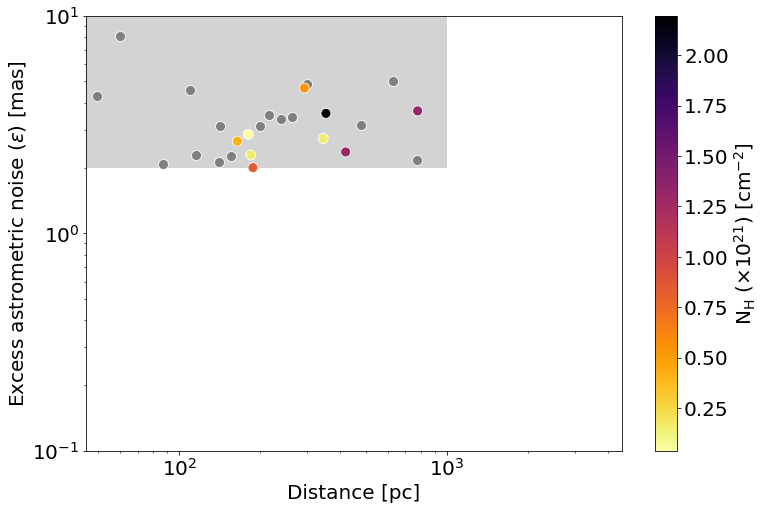

In [12]:
fig, ax = plt.subplots(figsize=(12,8))

ax.add_patch(mpl.patches.Rectangle((0,2),1000,50, edgecolor='none',facecolor='lightgrey',zorder=0))

sns.scatterplot(data=unobs[unobs["N_H"].isna()], x="rest", y="epsi", color="grey", marker="o", s=100, ax=ax, legend=False)
sns.scatterplot(data=unobs[~unobs["N_H"].isna()],x="rest",y="epsi",hue="N_H",palette="inferno_r",marker="o",s=100,ax=ax, legend=False)

ax.set(ylim=(1e-1,10), xlim=(45,4500), xscale="log", yscale="log", xlabel="Distance [pc]", ylabel="Excess astrometric noise ($\epsilon$) [mas]")

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=unobs["N_H"].min()/1e21, vmax=unobs["N_H"].max()/1e21, clip=False), cmap='inferno_r'),label='N$_\mathrm{H}$ (×$10^{21}$) [cm$^{-2}$]',ax=ax)

#fig.savefig("unobserved.png",bbox_to_inches="tight",dpi=300)